# **Gated Recurrent Unit Forecast - Reservoir Levels (Upper Niho)**


---



## **Libraries**

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import math

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

## **Load Data**

The data was obtained from 2 sources:
1.   Watercare Services Limited
2.   NIWA

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#shift_days = 7  
shift_steps = 7 

In [ ]:
#df= pd.read_csv('gdrive/My Drive/DL Project/Mangatangi/Mangatangi_All.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df= pd.read_csv('gdrive/My Drive/DL Project/Upper Niho/Upper_Niho_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

In [ ]:
#df.drop(['Rainfall (NIWA)', 'Max Temp', 'Vapour Pressure', 'Solar Radiation'], axis=1, inplace=True)
#df.drop(['Rainfall (WSL)'], axis=1, inplace=True)

In [ ]:
df_val = df[-365:]

In [ ]:
y_val = df_val['Level'].shift(-shift_steps)

In [ ]:
y_val = y_val[:-shift_steps]

In [ ]:
y_val

Date
2020-03-05    24.774
2020-03-06    24.649
2020-03-07    24.522
2020-03-08    24.392
2020-03-09    24.261
               ...  
2021-02-21    25.780
2021-02-22    25.704
2021-02-23    25.641
2021-02-24    25.670
2021-02-25    25.761
Name: Level, Length: 358, dtype: float64

In [ ]:
df_val = df_val[:-shift_steps]

In [ ]:
df = df[:-365]

Interpolating to handle missing values:

In [ ]:
df.isnull().sum()

Level                          0
Spill                          0
Rainfall (NiWa)                0
Rainfall (WSL)                 0
Vapour Pressure (hPa)          0
Observed Penman Evaporation    0
Abstraction (m3)               0
Compensation (m3)              0
Max Temp                       0
Soil Moisture                  0
Solar Radiation                0
Year sin                       0
Year cos                       0
dtype: int64

In [ ]:
df.values.shape

(3746, 13)

In [ ]:
df.tail()

,Level,Spill,Rainfall (NiWa),Rainfall (WSL),Vapour Pressure (hPa),Observed Penman Evaporation,Abstraction (m3),Compensation (m3),Max Temp,Soil Moisture,Solar Radiation,Year sin,Year cos
Date,,,,,,,,,,,,,
2020-02-29,26.908,0.0,0.0,0.00,16.8,4.8,16783.375,5304.5150,26.1,-137.8,20.3,0.8584,0.5130
2020-03-01,26.740,0.0,0.0,0.00,18.4,2.9,16735.750,5287.2935,23.3,-137.9,9.5,0.8671,0.4981
2020-03-02,26.571,0.0,5.5,0.00,19.8,4.0,16680.750,5293.0562,25.2,-132.4,13.5,0.8755,0.4831
2020-03-03,26.380,0.0,0.0,3.43,24.1,2.6,18714.000,5292.9750,23.1,-133.2,13.6,0.8837,0.4680
2020-03-04,26.179,0.0,0.0,5.98,15.7,3.0,21360.000,5277.9691,22.4,-134.2,13.3,0.8917,0.4527


### **Target**

The output we want to predict

In [ ]:
target = ['Level']

Shifting the target column to the number of steps ahead we want to forecast

In [ ]:
df_targets = df[target].shift(-shift_steps)

In [ ]:
df_targets.head()

,Level
Date,
2009-12-02,33.507
2009-12-03,33.385
2009-12-04,33.258
2009-12-05,33.134
2009-12-06,33.000


### **NumPy Array**



1.   Converting to NumPy array to feed into the neural network.
2.   Removing the 'NaN' values due to the shift.
3.   Train/test split









Input data

In [ ]:
x_data = df.values[0:-shift_steps]

In [ ]:
x_data

array([[29.792 ,  0.    , 34.3   , ..., 15.6   , -0.4821,  0.8761],
       [29.857 ,  0.    , 57.6   , ...,  5.3   , -0.467 ,  0.8843],
       [33.142 ,  0.    ,  0.    , ..., 24.1   , -0.4517,  0.8922],
       ...,
       [27.728 ,  0.    ,  0.    , ..., 23.1   ,  0.8112,  0.5848],
       [27.567 ,  0.    ,  0.    , ..., 24.5   ,  0.8211,  0.5708],
       [27.401 ,  0.    ,  0.    , ..., 20.2   ,  0.8308,  0.5566]])

In [ ]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (3739, 13)


Output data

In [ ]:
y_data = df_targets.values[:-shift_steps]

In [ ]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (3739, 1)


Number of observations/rows in the dataset

In [ ]:
num_data = len(x_data)
num_data

3739

Train/test fraction

In [ ]:
train_split = 0.85

Number of training and testing samples

In [ ]:
num_train = int(train_split * num_data)
num_test = num_data - num_train

print (f'Number of training samples: {num_train}')
print (f'Number of test samples: {num_test}')

Number of training samples: 3178
Number of test samples: 561


Input-signals for the training- and test-sets:

In [ ]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

3739

Output-signals for the training- and test-sets:

In [ ]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

3739

Number of input features

In [ ]:
num_x_signals = x_data.shape[1]
num_x_signals

13

Number of output signals

In [ ]:
num_y_signals = y_data.shape[1]
num_y_signals

1

### **Data Scaling**

Range of values from the dataset

In [ ]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -139.9
Max: 34101.375


Creating a scaler object for the inputs

In [ ]:
x_scaler = MinMaxScaler() #scaling data between 0 & 1

Scaling the training input data

In [ ]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [ ]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


Scaling the testing input data

In [ ]:
x_test_scaled = x_scaler.transform(x_test)

Scaling the output/target data. Note a separate scaling object (y_scaler) is created.

In [ ]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## **Data Generator**

The data has now been prepared as 2D NumPy arrays. 

In [ ]:
print(f'X Train Shape: {x_train_scaled.shape}')
print(f'Y Train Shape: {y_train_scaled.shape}')

X Train Shape: (3178, 13)
Y Train Shape: (3178, 1)


In [ ]:
print(f'X Test Shape: {x_test_scaled.shape}')
print(f'Y Test Shape: {y_test_scaled.shape}')

X Test Shape: (561, 13)
Y Test Shape: (561, 1)


A batch_generator function is used to create a batch of shorter sub-sequences picked at random from the training-data. 

In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Defining batch size

In [ ]:
batch_size = 5

Defining sequence length. Number of observations per batch

In [ ]:
sequence_length = 365
sequence_length

365

Assigning generator function

In [ ]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Testing the batch-generator

In [ ]:
x_batch, y_batch = next(generator)

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

(5, 365, 13)
(5, 365, 1)


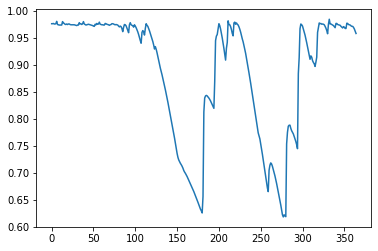

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

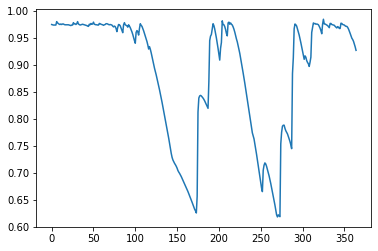

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### **Validation Set**

To overcome the risk of overfitting, the performance is monitored on the test set after each epoch and the models weights are saved only if the performance is improved on the test set. 


The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
re, er = validation_data

In [ ]:
re.shape

(1, 561, 13)

In [ ]:
er.shape

(1, 561, 1)

## **Gated Recurrent Unit (GRU)**

Recurrent Neural Network (RNN) is created using the Keras API.

**1st Hidden layer:**

The GRU will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by None), where each observation has a number of input-signals (num_x_signals).

**Dense layer:**

A fully-connected (or dense) layer is then added which maps 512 values down to only 1 value.

**Activation Function:**

A linear activation function is used on the output so that the output values can take on arbitary values and, unlike a sigmoid activation function, which maps outputs between 0 and 1, the linear activation output is not constrained by the values of the training data. 

In [ ]:
model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals)))


In [ ]:
from tensorflow.python.keras.initializers import RandomUniform

init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(num_y_signals, 
                activation='linear',
                kernel_initializer=init))
#if False:
  #from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    #init = RandomUniform(minval=-0.05, maxval=0.05)

    #model.add(Dense(num_y_signals,
                    #activation='linear',
                    #kernel_initializer=init))



### **Loss Function**

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [ ]:
warmup_steps = 50

In [ ]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse



### **Compile Model**

Optimizer

In [ ]:
#optimizer = RMSprop(lr=1e-3)
optimizer = Adam(lr=1e-3)

Compile the Keras model so it is ready for training.

In [ ]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         809472    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 809,985
Trainable params: 809,985
Non-trainable params: 0
_________________________________________________________________


### **Callback Functions**

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=8, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## **Training the Recurrent Neural Network**

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected steps_per_epoch 

In [ ]:
%%time
validation = model.fit(x=generator,
          epochs=70,
          steps_per_epoch=30,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/70
30/30 [==============================] - 3s 68ms/step - loss: 0.0920 - val_loss: 0.0064

Epoch 00001: val_loss improved from inf to 0.00639, saving model to 23_checkpoint.keras
Epoch 2/70
30/30 [==============================] - 1s 27ms/step - loss: 0.0046 - val_loss: 0.0042

Epoch 00002: val_loss improved from 0.00639 to 0.00420, saving model to 23_checkpoint.keras
Epoch 3/70
30/30 [==============================] - 1s 26ms/step - loss: 0.0024 - val_loss: 0.0034

Epoch 00003: val_loss improved from 0.00420 to 0.00336, saving model to 23_checkpoint.keras
Epoch 4/70
30/30 [==============================] - 1s 26ms/step - loss: 0.0022 - val_loss: 0.0025

Epoch 00004: val_loss improved from 0.00336 to 0.00253, saving model to 23_checkpoint.keras
Epoch 5/70
30/30 [==============================] - 1s 26ms/step - loss: 0.0020 - val_loss: 0.0022

Epoch 00005: val_loss improved from 0.00253 to 0.00218, saving model to 23_checkpoint.keras
Epoch 6/70
30/30 [==========================

**Load Checkpoint**

Because early-stopping was used when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### **Model Performance on Test Set**

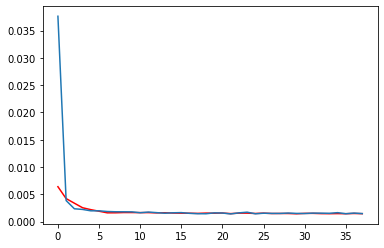

In [ ]:
plt.plot(validation.history['val_loss'], 'r', validation.history['loss'])

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 30ms/step - loss: 0.0014


In [ ]:
print("loss (test-set):", result)

loss (test-set): 0.0014207781059667468


In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))



---



## **Results**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
x = x_test_scaled
y_true = y_test

In [ ]:
start_idx = 0
length = 3000

In [ ]:
end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
x = x[start_idx:end_idx]
y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

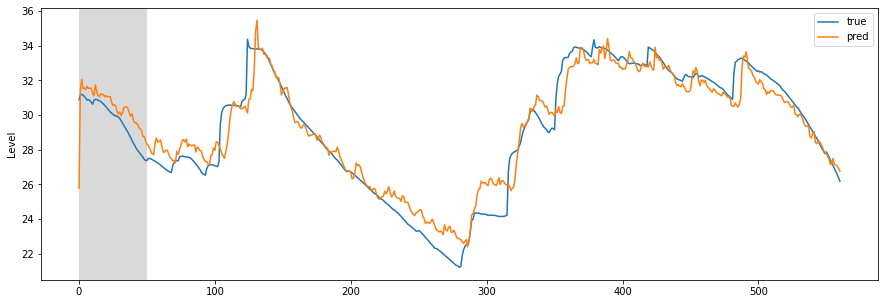

In [ ]:
for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')

        result_table = pd.DataFrame(signal_true)
        result_table['pred'] = pd.DataFrame(signal_pred)
    
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

        #MAE and MSE
        mae = mean_absolute_error(signal_true[10:],signal_pred[10:])
        mse = mean_squared_error(signal_true[10:],signal_pred[10:])
        rmse = math.sqrt(mean_squared_error(signal_true[10:], signal_pred[10:]))
        
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

### **Plotting Entire Dataset (Train, Test and Predictions)**

In [ ]:
x1 = x_train_scaled
y_true1 = y_train

No handles with labels found to put in legend.


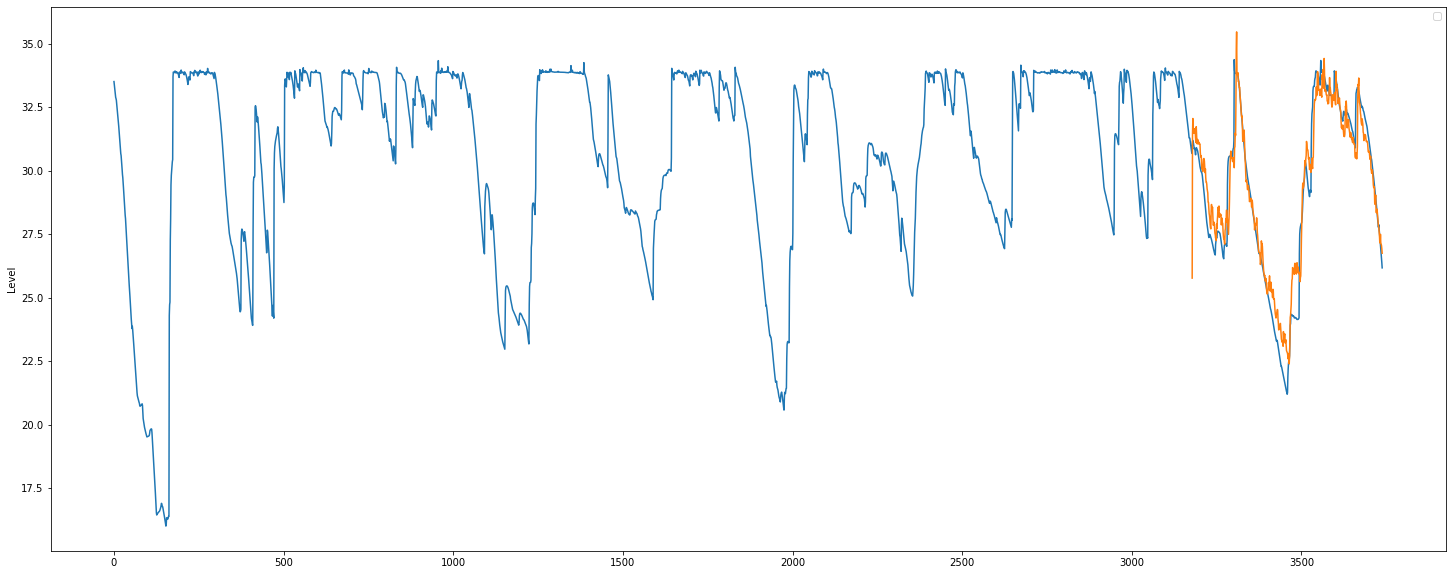

In [ ]:
# For each output-signal.
for signal in range(len(target)):
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:, signal]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true1[:, signal]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(25,10))
    
    # Plot and compare the two signals.
    plt.ylabel(target[signal])
    plt.legend()
    plt.plot(y_data, label='true')
    plt.plot([None for x in y_true1] + [x for x in signal_pred], label='pred')
    plt.show()


### **Evaluating forecast accuracy**

Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

In [ ]:
print(f'mean absolute error {mae}')
print(f'mean squared error {mse}')
print (f'root mean squared error {rmse}')

mean absolute error 0.7094004752822018
mean squared error 0.9158492716334599
root mean squared error 0.9570001419192475




---



## **Results as Function**

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')

        result_table = pd.DataFrame(signal_true)
        result_table['pred'] = pd.DataFrame(signal_pred)
    
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

        #MAE and MSE
        error = mean_absolute_error(signal_true,signal_pred)
        
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()
     
        return result_table
        return error

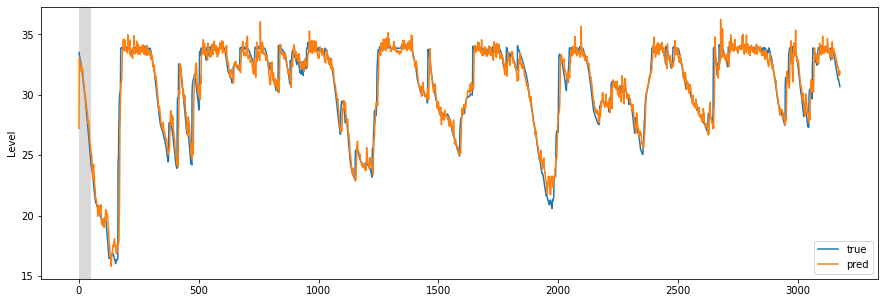

,0,pred
0,33.507,27.229034
1,33.385,32.588379
2,33.258,33.062927
3,33.134,32.698215
4,33.000,32.704842
...,...,...
3173,31.070,31.830053
3174,30.997,31.572348
3175,30.883,31.880985
3176,30.765,31.989319


In [ ]:
plot_comparison(start_idx=0, length=3500, train=True)

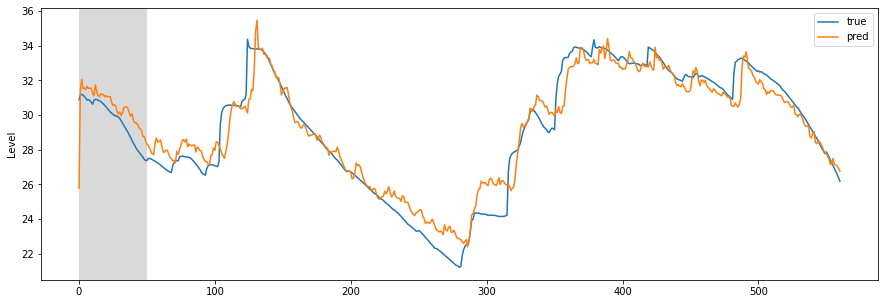

,0,pred
0,30.886,25.775736
1,31.154,31.475576
2,31.190,32.055042
3,31.143,31.512711
4,31.066,31.563890
...,...,...
556,26.908,27.143444
557,26.740,27.115156
558,26.571,27.056547
559,26.380,26.929516


In [ ]:
plot_comparison(start_idx=00, length=2000, train=False)

# **Saving and Running Model**

In [ ]:
#df_val #y_val

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#model.save(f"GRU_Mangatangi_{shift_steps}Day.h5")

In [ ]:
#model_2 = load_model(f'/content/GRU_Mangatangi_{shift_steps}Day.h5', compile=False)

In [ ]:
x_test2 = df_val.values

In [ ]:
x_test2.shape

(358, 13)

In [ ]:
x_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
x_test2_scaled = x_scaler.transform(x_test2)

In [ ]:
x2 = x_test2_scaled    
    # Input-signals for the model.
x2 = np.expand_dims(x2, axis=0)

In [ ]:
x2.shape

(1, 358, 13)

In [ ]:
#y_pred2 = model2.predict(x2)
y_pred2 = model.predict(x2)

In [ ]:
y_pred_rescaled2 = y_scaler.inverse_transform(y_pred2[0])

In [ ]:
result_df = pd.DataFrame(y_val)

In [ ]:
result_df['pred'] = y_pred_rescaled2

In [ ]:
y_pred_rescaled2.shape

(358, 1)

In [ ]:
result_df

,Level,pred
Date,,
2020-03-05,24.774,24.165440
2020-03-06,24.649,27.281494
2020-03-07,24.522,25.654369
2020-03-08,24.392,24.512325
2020-03-09,24.261,24.072306
...,...,...
2021-02-21,25.780,25.881571
2021-02-22,25.704,25.754425
2021-02-23,25.641,25.555033


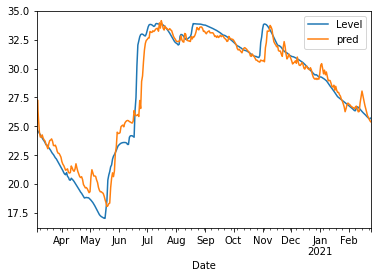

In [ ]:
result_df.plot()

In [ ]:
rmse = math.sqrt(mean_squared_error(y_val[10:], y_pred_rescaled2[10:]))
mae = math.sqrt(mean_squared_error(y_val[10:], y_pred_rescaled2[10:]))
print(rmse)

1.1934151986538308


In [ ]:
#mse = mean_squared_error(y_val[10:], y_pred_rescaled2[10:])
rmse = math.sqrt(mean_squared_error(y_val[10:], y_pred_rescaled2[10:]))
mae = mean_absolute_error(y_val[10:], y_pred_rescaled2[10:])
#print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 1.1934151986538308
MAE: 0.7580517382128483
